# Compute metrics using HOI package

Import libraries

In [120]:
import numpy as np
import pandas as pd
import hoi
from hoi.plot import plot_landscape
from hoi.utils import get_nbest_mult
from numpy import random
import matplotlib.pyplot as plt
from hoi.metrics import InfoTopo, TC, DTC, Sinfo, Oinfo, RedundancyphiID, SynergyphiID

Define functions

In [ ]:
# Function to compute a desired information metric
def compute_information_metric(metric):
    model = metric(data_array)
    metric_results=model.fit(minsize=2,maxsize=5)
    return metric_results

Create random timeseries to test

In [ ]:
n_timesteps = 100
n_variables = 20  

data = np.random.randn(n_timesteps, n_variables)
columns = [f'X{i+1}' for i in range(n_variables)]
df = pd.DataFrame(data, columns=columns)
data_array=np.array(np.array(df)).astype(float)

Compute metric values (choose from InfoTopo, TC, DTC, Sinfo, Oinfo, RedundancyphiID, SynergyphiID)

In [122]:
metric_values = compute_information_metric(RedundancyphiID)

    Copnorm and demean the data
Get list of multiplets


  0%|          |  0/4 [00:00<?,       ?it/s]

Plot metric landscape

<Axes: xlabel='Order', ylabel='Topological Information [Bits]'>

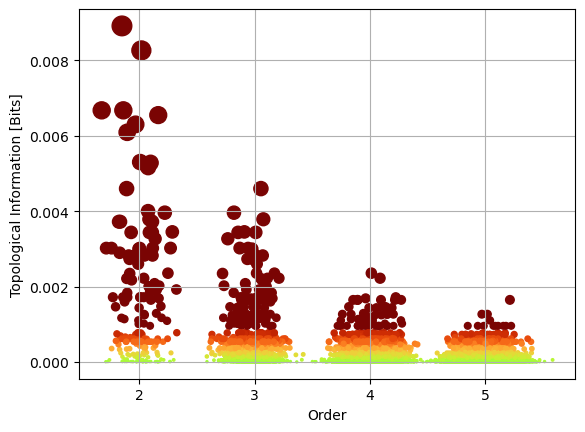

In [ ]:
plot_landscape(
    metric_values,
    model,
    kind="scatter",
    undersampling=False,
    plt_kwargs=dict(cmap="turbo"),
)